In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

In [3]:
''' crystal variables  '''
crystal_type='111'
ang_as = np.deg2rad(5)           # asymmetric angle

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638         # reflecting plane d-spacing [A]
    psi0r = -9.964087683e-6      # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.554410972e-7       # imaginary part of ""
    psi_hr = -5.264819463e-6     # real part of Hth Fourier component
    psi_hi = 1.085248779e-7      # imaginary part of ""
    psi_hbr = -5.264819463e-6    # real part of -Hth Fourier coumponent
    psi_hbi = 1.085248779e-7     # imaginary part of ""
    
tc = 150e-6                       # crystal thickness
uc = 1                            # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = 0                 # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)


In [4]:
''' incident beam variables '''
ekev = 9.9                  # photon energy [kev]
pulse_duration = 3e-15    # pulse duration (rms) [s]
trange = 4000e-15


In [5]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/' 
mkdir(strDataFolderName)

# sub-folder for current sampling condition
dirname_case = strDataFolderName+'ray_tracing/'
mkdir(dirname_case)
    
# sub-sub-folder for current sampling parameters
dirname_duration = dirname_case+'{} fs/'.format(
    round(pulse_duration*1e15,1))
mkdir(dirname_duration)

# incident beam
dirname_input = dirname_duration+'incident_beam/'
mkdir(dirname_input)

# propagated beam, mono
dirname_mono = dirname_duration+'mono/'
mkdir(dirname_mono)

# propagated beam, spectrometer
dirname_spectrometer = dirname_duration+'spectrometer/'
mkdir(dirname_spectrometer)


path exists
path exists
path exists
path exists
path exists
path exists


# Define beamline optics

In [6]:
''' analyzer lens '''
f_OE = 10.

OE = SRWLOptL(_Fx=1e30, _Fy=f_OE, _x=0, _y=0)

''' analyzer crystal '''
C5 = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)
set_crystal_orient(C5, ekev*1e3, ang_dif_pl, flip=0)


### Define beamline

In [7]:
''' drift between OE '''
z_C5_OE = .1
z_OE_Im = f_OE

D_C5_OE = SRWLOptD(z_C5_OE)
D_OE_Im = SRWLOptD(z_OE_Im)

''' propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppC5 =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_C5_OE =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppOE =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppD_OE_Im =      [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' beamline '''
name2_VCC = 'VCC_3.spectrometer'
name2_CC = 'CC_3.spectrometer'

BL_Spectrometer = SRWLOptC([C5, D_C5_OE, OE, D_OE_Im],
               [ppC5, ppD_C5_OE, ppOE, ppD_OE_Im])

print('done')

done


In [8]:
''' propagation '''
name1_VCC = 'VCC_2.mono'
name1_CC = 'CC_2.mono'
fname_VCC1 = dirname_mono + 'wf_{}.h5'.format(name1_VCC)
fname_CC1 = dirname_mono + 'wf_{}.h5'.format(name1_CC)

# branch 1 (VCC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through VCC, t = {}s'.format(round(time.time()-startTime,2)))
fname_VCC2 = dirname_spectrometer + 'wf_{}.h5'.format(name2_VCC)
mwf_VCC2 = propagate_wavefront(fname_VCC1, BL_Spectrometer, fname_VCC2)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# branch 2 (CC)
startTime = time.time(); tstamp = time.time()
print('\n\n*** through CC, t = {}s'.format(round(time.time()-startTime,2)))
fname_CC2 = dirname_spectrometer + 'wf_{}.h5'.format(name2_CC)
mwf_CC2 = propagate_wavefront(fname_CC1, BL_Spectrometer, fname_CC2)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))




*** through VCC, t = 0.0s
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = 0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 9900.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9935280298512542
	nvz = -0.11358720834620997
	psi0i = 1.554410972e-07
	psi0r = -9.964087683e-06
	psiHbi = 1.085248779e-07
	psiHbr = -5.264819463e-06
	psiHi = 1.085248779e-07
	psiHr = -5.264819463e-06
	tc = 0.00015
	tvx = 0
	tvy = 0.11358720834620997
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.1
	treat = 0
	
Optical Element: Thin Lens
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+30
	Fy = 10.0
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10.0
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx   256  range_x [-1.0e+00, 1.0e+00] mm
ny   256  range_y [-1.0e+00, 1.0e+00] mm
*****prop

# Plots

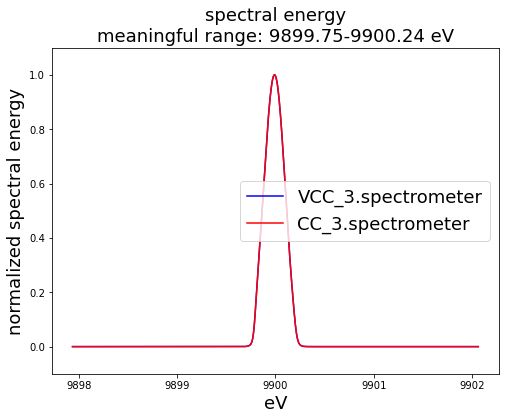

In [9]:
''' spectrum '''
aw_VCC, axis_VCC, int_VCC = get_spectra(mwf_VCC2)
aw_CC, axis_CC, int_CC = get_spectra(mwf_CC2)

plt.figure(figsize=(8,6))
plot_spectra(aw_VCC, axis_VCC, int_VCC, 'b', label=name2_VCC)
plot_spectra(aw_VCC, axis_VCC, int_VCC, 'r', label=name2_CC)

plt.savefig(dirname_spectrometer+'spectrum_all.png',transparent=True)


R-space
R-space
R-space
R-space
R-space
R-space
R-space
R-space


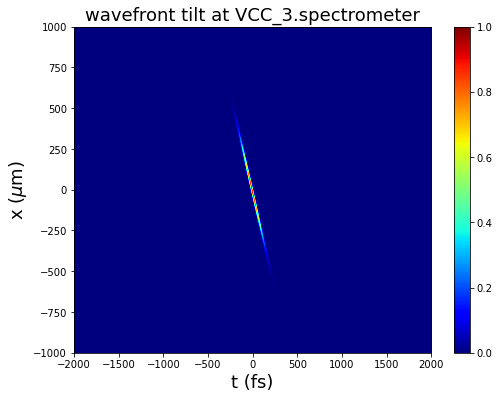

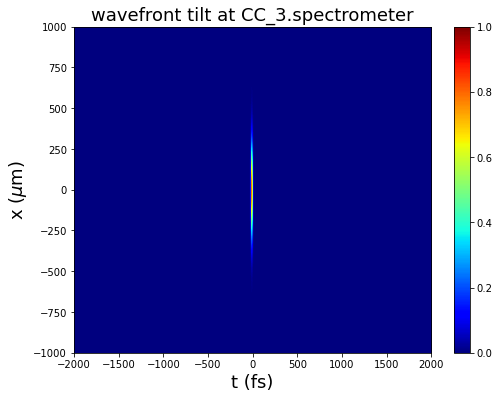

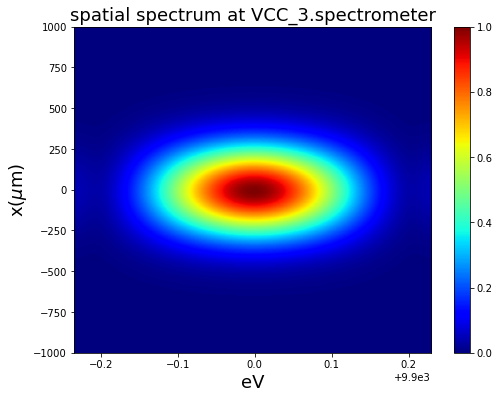

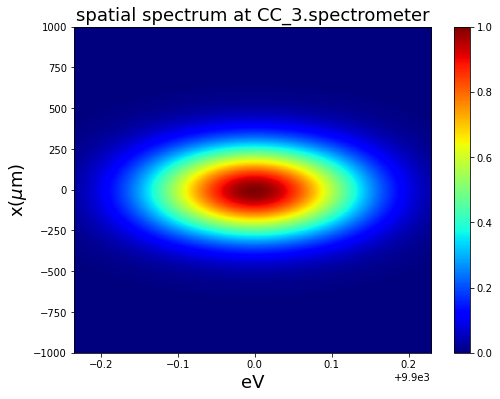

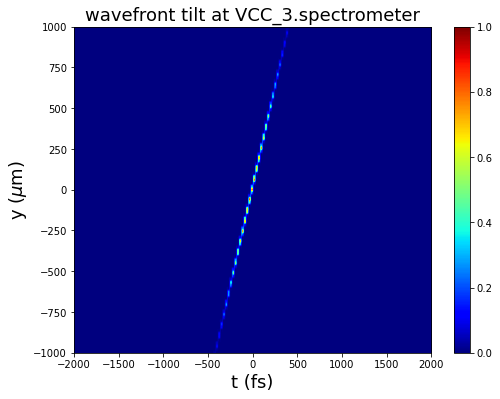

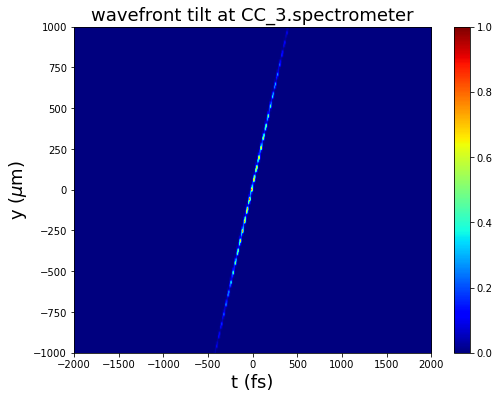

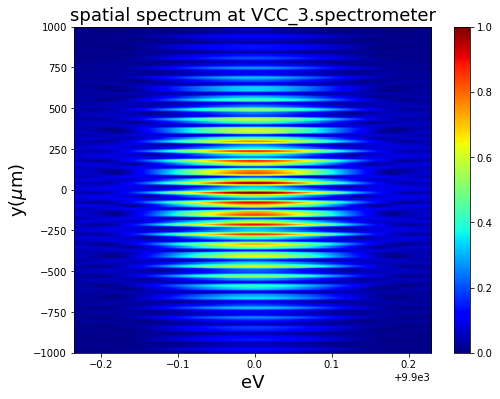

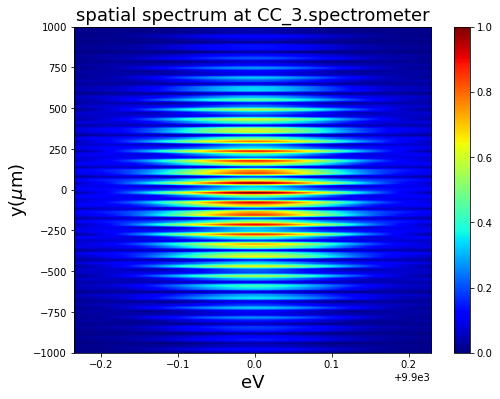

In [10]:
''' tilt and spectrum '''
if_log = 0
fov_y = 2000      # um
fov_t = trange*1e15    # fs
eStart = axis_CC[aw_CC.min()]
eFin = axis_CC[aw_CC.max()]
for dim in ['x','y']:
    if dim == 'y': ori = 'V'
    else: ori = 'H'

    plt.figure(figsize=(8,6))
    plot_tilt_from_wf(mwf_VCC2,label=name2_VCC,if_log=if_log, ori=ori)
    plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_spectrometer+'tilt_{}_{}.png'.format(dim,name2_VCC),transparent=True)

    plt.figure(figsize=(8,6))
    plot_tilt_from_wf(mwf_CC2,label=name2_CC,if_log=if_log, ori=ori)
    plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_spectrometer+'tilt_{}_{}.png'.format(dim,name2_CC),transparent=True)
    
    plt.figure(figsize=(8,6))
    plot_tilt_freq_from_wf(mwf_VCC2,label=name2_VCC,if_log=0, ori=ori)
    plt.xlim([eStart, eFin]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_spectrometer+'spectrum_{}_{}.png'.format(dim,name2_VCC),transparent=True)
    
    plt.figure(figsize=(8,6))
    plot_tilt_freq_from_wf(mwf_CC2,label=name2_CC,if_log=0, ori=ori)
    plt.xlim([eStart, eFin]); plt.ylim([-fov_y/2,fov_y/2])
    plt.savefig(dirname_spectrometer+'spectrum_{}_{}.png'.format(dim,name2_CC),transparent=True)


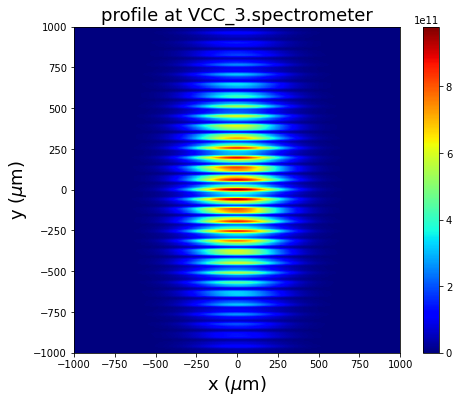

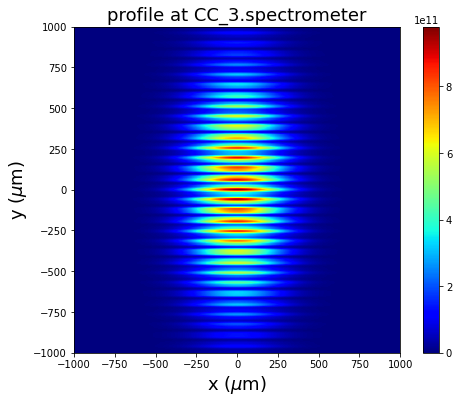

In [11]:
''' profile '''
if_log = 0
fov = 2000
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plot_spatial_from_wf(mwf_VCC2, label=name2_VCC, if_log=if_log)
plt.xlim([-fov/2,fov/2]); plt.ylim([-fov/2,fov/2])
ax1.set_aspect('equal')
plt.savefig(dirname_spectrometer+'profile_{}.png'.format(name2_VCC),transparent=True)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plot_spatial_from_wf(mwf_CC2, label=name2_CC, if_log=if_log)
plt.xlim([-fov/2,fov/2]); plt.ylim([-fov/2,fov/2])
ax1.set_aspect('equal')
plt.savefig(dirname_spectrometer+'profile_{}.png'.format(name2_CC),transparent=True)


In [12]:
''' sum '''
E_real_VCC, E_img_VCC = interp_wf(mwf_VCC2, mwf_CC2)
x_CC, y_CC, E_real_CC, E_img_CC = get_field(mwf_CC2)

img = np.square(np.abs(E_real_VCC+E_real_CC + 1j*(E_img_VCC+E_img_CC)))

In [ ]:
fov = 2000
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
plot_spatial(x_CC, y_CC, E_real_VCC+E_real_CC, E_img_VCC+E_img_CC, label='Sum', if_log=0)
plt.xlim([-fov/2,fov/2]); plt.ylim([-fov/2,fov/2])
ax1.set_aspect('equal')
plt.savefig(dirname_spectrometer+'profile_Sum.png', transparent=True)

In [ ]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)